In [29]:
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation as nx_app
import math
from time import perf_counter
import numpy as np
import itertools
import pandas as pd


In [22]:
def tsp_graph(cities: int = 20):
    G = nx.random_geometric_graph(cities, radius=0.4, seed=3)
    pos = nx.get_node_attributes(G, "pos")

    # Depot should be at (0,0)
    pos[0] = (0.5, 0.5)

    # H = G.copy()

    distance_matrix = np.zeros((cities, cities))
    # Calculating the distances between the nodes as edge's weight.
    for i in range(len(pos)):
        for j in range(i + 1, len(pos)):
            dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
            distance_matrix[i, j] = dist
            G.add_edge(i, j, weight=dist)

    distance_matrix += distance_matrix.T

    return G, pos, distance_matrix


In [69]:
def tsp_graph_vis(G, pos, path=[]):
    # Draw edges if not path given

    if not path:
      nx.draw_networkx_edges(G, pos, edge_color="blue", width=0.5)

    # path edge list
    edge_list = list(nx.utils.pairwise(path))

    # Draw the route
    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        edgelist=edge_list,
        node_color = 'r',
        edge_color="red",
        node_size=200,
        width=3,
    )



In [43]:
def compute_distance(distance_matrix: np.ndarray, path: list) -> tuple[int, np.ndarray]:
    ind_y = path
    ind_x = path[1:] + path[:1]
    return distance_matrix[ind_y, ind_x].sum(), distance_matrix[ind_y, ind_x]

In [ ]:
start_point = 0
G, pos, distance_matrix  = tsp_graph(6)
tsp_graph_vis(G, pos)
pd.DataFrame(distance_matrix)

In [31]:
def brute_force_tsp(distance_matrix: np.ndarray, start: int) -> tuple[list[int], float]:
    points = list(range(distance_matrix.shape[0]))
    points.remove(start)

    best_distance = np.inf
    best_permutation = []

    start_time = perf_counter()

    for perm in itertools.permutations(points):
        distance = distance_matrix[start, perm[0]]  # Distance from start to first point
        for i in range(len(perm) - 1):
            distance += distance_matrix[perm[i], perm[i + 1]]  # Distance between intermediate points
        distance += distance_matrix[perm[-1], start]  # Distance from last point back to start

        if distance < best_distance:
            best_distance = distance
            best_permutation = [start] + list(perm) + [start]

    compute_time = perf_counter() - start_time

    return best_permutation, compute_time

In [ ]:
path, compute_time = brute_force_tsp(distance_matrix, 0)
print("Optimal path: ", path, "Distance: ", compute_distance(distance_matrix, path)[0], "Time: ", compute_time, 's')
tsp_graph_vis(G, pos, path)
plt.title(f'Optimal, distance: {compute_distance(distance_matrix, path)[0]}')

In [ ]:
# Brute force algorithm complexity

times = []
for i in range(2, 12):
  _, _, distance_matrix_test  = tsp_graph(i)
  _, compute_time = brute_force_tsp(distance_matrix_test, 0)
  print(f'Cities: {i}, computation time: {compute_time} s')
  times.append(compute_time)
plt.plot(range(2, 12), times)

In [41]:
def greedy_tsp(distance_matrix: np.ndarray, start: int) -> tuple[list[int], float]:
    points = list(range(distance_matrix.shape[0]))
    points.remove(start)

    visited = [start]
    next_point = start

    start_time = perf_counter()

    while points:
        distances = distance_matrix[next_point, points]
        min_distance_index = np.argmin(distances)
        next_point = points.pop(min_distance_index)
        visited.append(next_point)

    visited.append(start)  # Return to the starting point

    compute_time = perf_counter() - start_time

    return visited, compute_time

In [ ]:
# Greedy algorithm

path, compute_time = greedy_tsp(distance_matrix, 0)
print("Path: ", path, "Distance: ", compute_distance(distance_matrix, path)[0], "Time: ", compute_time, 's')
tsp_graph_vis(G, pos, path)
plt.title(f'Greedy, distance: {compute_distance(distance_matrix, path)[0]}')

In [ ]:
# Greedy force algorithm complexity

times = []
for i in range(2, 30):
  _, _, distance_matrix_test  = tsp_graph(i)
  _, compute_time = greedy_tsp(distance_matrix_test, 0)
  print(f'Cities: {i}, computation time: {compute_time} s')
  times.append(compute_time)
plt.plot(range(2, 30), times)

In [51]:
def mst_approx_tsp(distance_matrix: np.ndarray, start: int) -> tuple[list[int], float]:
    import numpy as np
    from scipy.sparse.csgraph import minimum_spanning_tree
    from collections import defaultdict

    num_cities = distance_matrix.shape[0]

    start_time = perf_counter()

    # Compute the MST
    mst_sparse = minimum_spanning_tree(distance_matrix)
    mst_matrix = mst_sparse.toarray()
    mst_matrix += mst_matrix.T  # Make the MST undirected

    # Build adjacency list from MST
    adjacency_list = defaultdict(list)
    for i in range(num_cities):
        for j in range(num_cities):
            if mst_matrix[i, j] > 0:
                adjacency_list[i].append(j)

    # Perform pre-order traversal (DFS)
    visited = []
    visited_set = set()

    def dfs(u):
        visited.append(u)
        visited_set.add(u)
        for v in adjacency_list[u]:
            if v not in visited_set:
                dfs(v)

    dfs(start)
    visited.append(start)  # Return to starting city

    compute_time = perf_counter() - start_time

    return visited, compute_time

In [ ]:
# minimum spanning tree algorithm

path, compute_time = mst_approx_tsp(distance_matrix, 0)
print("Path: ", path, "Distance: ", compute_distance(distance_matrix, path)[0], "Time: ", compute_time, 's')
tsp_graph_vis(G, pos, path)
plt.title(f'MST, distance: {compute_distance(distance_matrix, path)[0]}')

In [ ]:
# Minimum spanning tree algorithm complexity

times = []
for i in range(2, 30):
  _, _, distance_matrix_test  = tsp_graph(i)
  _, compute_time = mst_approx_tsp(distance_matrix_test, 0)
  print(f'Cities: {i}, computation time: {compute_time} s')
  times.append(compute_time)
plt.plot(range(2, 30), times)

Path:  [0, 5, 2, 4, 3, 1, 0] Distance:  2.692582206214078 Time:  0.0011274590001448814 s


Text(0.5, 1.0, 'christofides, distance: 2.692582206214078')

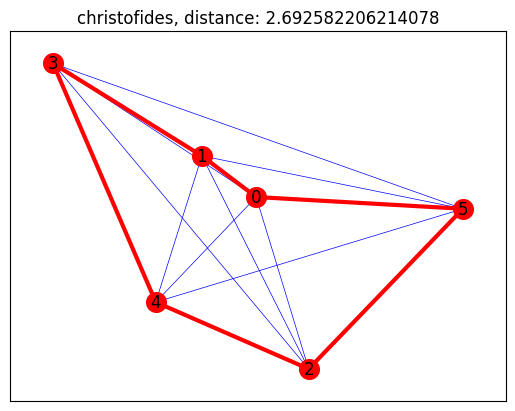

In [62]:
# Christofides algorithm
path = nx_app.christofides(G, weight="weight")
print("Path: ", path, "Distance: ", compute_distance(distance_matrix, path)[0], "Time: ", compute_time, 's')
tsp_graph_vis(G, pos, path)
plt.title(f'christofides, distance: {compute_distance(distance_matrix, path)[0]}')

In [ ]:
cities = 20
G, pos, distance_matrix  = tsp_graph(cities)
tsp_graph_vis(G, pos)
plt.title('Travelling salesman problem')
pd.DataFrame(distance_matrix)

path, compute_time = greedy_tsp(distance_matrix, 0)
plt.figure()
tsp_graph_vis(G, pos, path)
plt.title(f'Greedy, distance: {compute_distance(distance_matrix, path)[0]}')

path, compute_time = mst_approx_tsp(distance_matrix, 0)
plt.figure()
tsp_graph_vis(G, pos, path)
plt.title(f'MST, distance: {compute_distance(distance_matrix, path)[0]}')

path = nx_app.christofides(G, weight="weight")
plt.figure()
tsp_graph_vis(G, pos, path)
plt.title(f'Christofides, distance: {compute_distance(distance_matrix, path)[0]}')